In [ ]:
"""
https://jmetzen.github.io/2015-11-27/vae.html
예제4: VAE
참고문헌: Auto-Encoding Variational Bayes - Kingma and Welling (2013)
"""

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

# Load MNIST data in a format suited for tensorflow.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)
n_samples = mnist.train.num_examples


In [ ]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of neural network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32) #shape(fan_in, fan_out), low부터 high까지의 random uniform

class VAE(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, #tf.nn.softplus 매끄럽게 만든 ReLU 함수: log(exp(x) + 1)
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession() #InteractiveSession() installs itself as the default session on construction.
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture) 
        #**kwargs는 keyword argument를 dictionary로 저장

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent space
        self.z_mean, self.z_log_sigma_sq = \
            self._encoder_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])
        # all_weights : xavier_init을 통해 뽑은 수들로 처음에는 아무 수가 추출됨 
        #  ---> 학습시키면서 점점 정규분포를 따르는 z를 형성하게 됨.

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32) 
        #tf.random_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None) 정규분포
        
        # 
        self.x_reconstr_mean = \
            self._decoder_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _encoder_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) #tf.matmul(a,b) a*b의 행렬연산
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean']) 
        
        #구한 z로 mean 구하는게 아니라 random하게? --> transform, generate에서 하는 거
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        
        return (z_mean, z_log_sigma_sq)

    def _decoder_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        
        return x_reconstr_mean

    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        
        # 평소쓰던 crossentrophy의 손실식
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),1)
        #Bernoulli MLP as decoder이용
        #tf.reduce_sum(A,b) : 텐서 A의 축 b를 따라 합 반환. 1 -행
        # - 붙여서 minimize
        
        
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        #KL distance이용 : 분포사이의 차이를 구할 수있음 --> 분포에 대한 loss
        
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq),1)
        #tf.reduce_sum(A,b) : 텐서 A의 축 b를 따라 합 반환. 1 -행
        
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   
        # average over batch
        
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    
    ### fit 시킴.------ 위에 있는 x_reconst_mean, z, loss 다 여기에 연관됨. 
    # cost 함수를 통해서 autoencoding과 분포가 조정됨. --> z값이 정규분포를 가지게 만들어줌
    
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X})
        return cost
    #배치 사이즈로 fit을 돌려 cost 받음
    
    
    
    ### 새로운 이미지 데이터를 생성시킴.
    
    def transform(self, X):
        """Transform data by mapping it into the
        
        latent space."""
        #Note: This maps to 
        # mean of distribution, 
        #we could alternatively sample from Gaussian distribution
        
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    #인코더를 통해 z-mean을 받아서 나타내는 연산을 feed_dict을 넣어 수행해줌.
    
    def generate(self, z_mu=None):
        """ Generate data by 
        
        sampling from latent space.
        
        # If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from 
        prior in latent space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        
        # Note: This maps to 
        # mean of distribution, 
        #  we could alternatively sample from Gaussian distribution
        
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.z: z_mu})
    # z-mu를 입력값으로 없으면 생성해줌.
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.x: X})
    
    #run을 self.x_reconstr_mean이 함수로 돌림
#     self.x_reconstr_mean = \
#             self._decoder_network(network_weights["weights_gener"],
#                                     network_weights["biases_gener"])

In [ ]:
#We can now define a simple fuction which trains the VAE using mini-batches:        
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VAE(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size) #n_samples = mnist.train.num_examples # 배치 100
        # 수를 계산
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            #batch x,y 가 나옴.

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            #cost =
            
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        # 5구간마다 print해줌
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

In [ ]:
#We can now train a VAE on MNIST by just specifying the network topology. 
#We start with training a VAE with a 20-dimensional latent space.
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=36)

#Based on this we can sample some test inputs and visualize 
#how well the VAE can reconstruct those. In general the VAE does really well.
x_sample = mnist.test.next_batch(100)[0] #이미지 sample들을 담고 
x_reconstruct = vae.reconstruct(x_sample) #새로운 이미지를 생성해줌.

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Epoch: 0001 cost= 174.409682146
Epoch: 0006 cost= 108.615808230
Epoch: 0011 cost= 103.396826754
Epoch: 0016 cost= 101.251977539
Epoch: 0021 cost= 99.906535464
Epoch: 0026 cost= 98.941273610
Epoch: 0031 cost= 98.226503254
Epoch: 0036 cost= 97.534815202


C:\Users\Affinity\.conda\envs\keras\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 188.762118031
Epoch: 0006 cost= 153.105362355
Epoch: 0011 cost= 147.894659729
Epoch: 0016 cost= 145.358125472
Epoch: 0021 cost= 143.754148268
Epoch: 0026 cost= 142.719646579
Epoch: 0031 cost= 141.867958610
Epoch: 0036 cost= 141.258169084


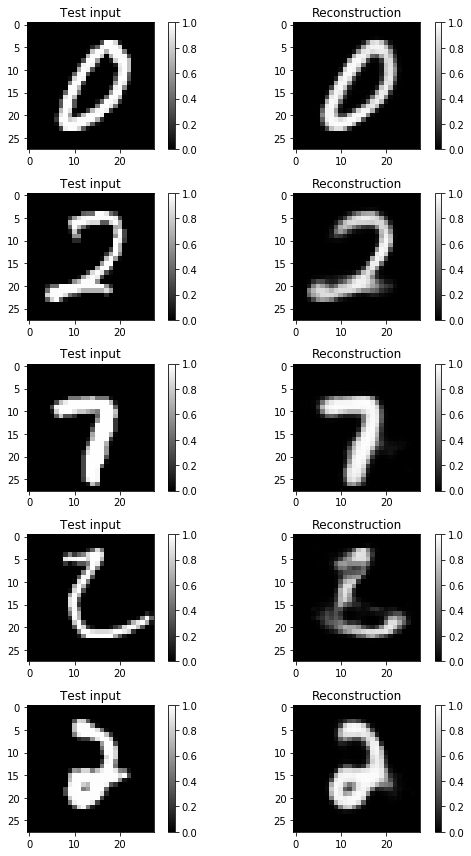

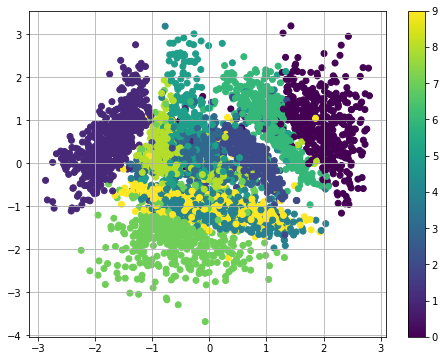

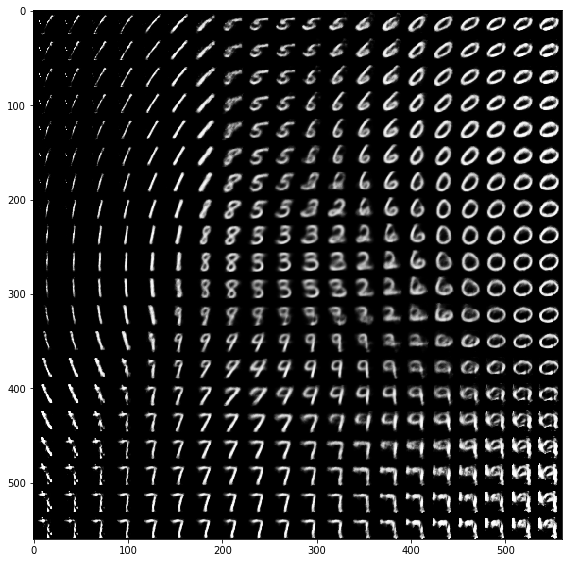

In [7]:
#=========== Illustrating latent space ===============#
#Next, we train a VAE with 2d latent space and illustrates 
#how the encoder (the recognition network) encodes some of 
#the labeled inputs (collapsing the Gaussian distribution 
#in latent space to its mean). This gives us some insights into 
#the structure of the learned manifold (latent space)

network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=36)

x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

nx = ny = 20 #-3,3까지 분포하는 걸 확인하고 20구간으로 나눔.
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)
        #x 축가장 끝 y 축 가장 첫번째 부터 그려짐 20X20

#An other way of getting insights into the latent space is to use 
#the generator network to plot reconstrunctions at the positions 
#in the latent space for which they have been generated:
plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()